In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler


# Synthetic non-linear data
np.random.seed(42)
X = np.linspace(-3, 3, 300).reshape(-1, 1)
y = np.sin(X).ravel() + 0.3*np.random.randn(300)

# Linear PLSR Example (skip this in class, but leave here as a demo?)
# Synthetic linear data to demonstrate linear PLSR
#np.random.seed(42)
#X = np.random.rand(200, 5)
#y = 3*X[:, 0] + 2*X[:, 1] + np.random.randn(200) * 0.1  # linear relation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, label="train data", alpha=0.3, color='blue', s=25)
plt.scatter(X_test, y_test, label="test data", alpha=0.3, color='red', s=25)
plt.xlabel("X"); plt.ylabel("y") 
plt.grid()
plt.legend()

#pls = PLSRegression(n_components=2)
#pls.fit(X_train, y_train)
#y_pred = pls.predict(X_test)

#print("Linear PLS R2:", r2_score(y_test, y_pred))

#plt.scatter(y_test, y_pred, alpha=0.7)
#plt.xlabel("True y")
#plt.ylabel("Predicted y")
#plt.title("Linear PLS Regression")
#plt.show()

# Non linear PLSR

**PLSR**:
* Step 1: Feature preparation
* Step 2: Extracting latent variables that maximize covariance between predictors and responses.
* Step 3: Regressing the response on these latent variables (using least square approach).

**Linear PLSR** assumes linear relationship between predictors and responses.
* Latent variables as a linear combination of explanatory variables $LV = B*X$
* Regression model as a linear combination of the latent variables $Y = W*LV$ 

How to derive a regression model that captures non-linear relationships?

In [65]:
#Example where linear PLSR fail (non-linear data)

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

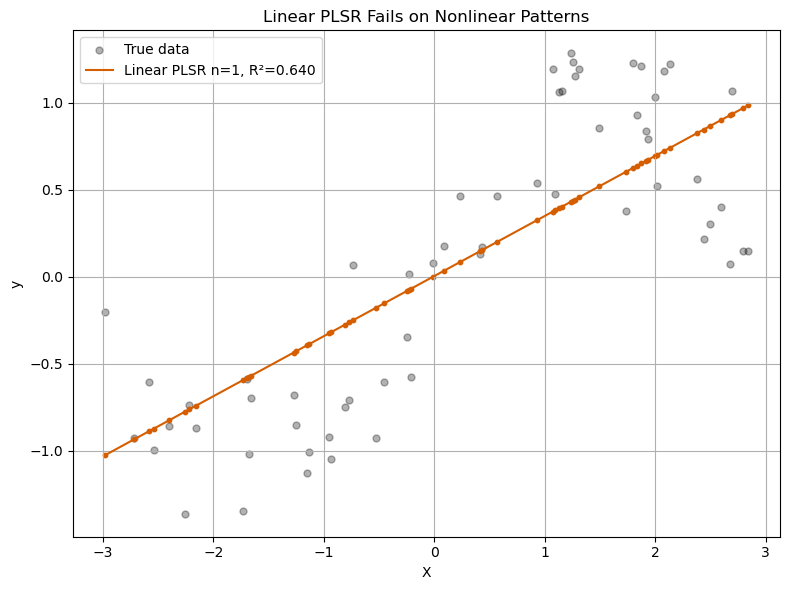

In [66]:
# Sort for smooth plotting
sorted_idx = np.argsort(X_test.ravel())
X_sorted = X_test[sorted_idx]
y_sorted = y_pred[sorted_idx]

# Color-blind friendly palette
colors = {
    "linear": "#D55E00",  # vermillion
    "true": "#000000"     # black
}

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label="True data", alpha=0.3, color=colors["true"], s=25)
plt.plot(X_sorted, y_sorted, label=f"Linear PLSR n=1, R²={r2_score(y_test, y_pred):.3f}", color=colors["linear"], linewidth=1.5)
plt.scatter(X_sorted, y_sorted, color=colors["linear"], s=10)

plt.title("Linear PLSR Fails on Nonlinear Patterns")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Introducing non-linearity in PLSR 

**Step 1: Feature preparation: Modifing the feature space before deriving latent variables**
* Method 1: Augment the predictor matrix with polynomial terms
* Method 2: Use Kernel functions to map the original data into higer dimensional feature space

**Step 2: Extraction of latent variables**
* Unchanged to maintain the strenghts of PLSR 

**Step 3: Derivation of regression model**
* Method 3: Use a spline function 
* Method 4: Use a NN to model the relationship between the latent variables and the responses
* Method 5: Local Weighted PLSR - Applies PLSR locally around each prediction point using a weighted neighborhood.


## Step 1: Modifing the feature space before deriving latent variables

### Method 1: Augment the predictor matrix with polynomial terms
* Explicit creation of new features by adding terms such as $x_1^2, x_2^2, x_1 x_2, ...$
* Easy to interpret
* Not computationally effective 

also called "non-linear PLSR via input transformation"

### Method 2: Use Kernel functions $K(x_i, x_j)$ ("Kernel PLSR")
* Implicit projection of original data into higer-dimensional feature space
* Harder to interpret
* More computationaly eficient

Note: The PLSR algorithm is adapted to work with the kernel matrix K, which replaces the original X. Therefore the higher-dimensional feature space is not explicitly constructed!

In [59]:
# ---- Method 1: Polynomial feature expansion (explicit transformation) --------------------
degree = 5  # Degree of polynomial expansion
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit PLSR with different numbers of components on polynomial features
pls_poly_1 = PLSRegression(n_components=1)
pls_poly_1.fit(X_poly_train, y_train)
y_pred_poly_1 = pls_poly_1.predict(X_poly_test)

pls_poly_2 = PLSRegression(n_components=2)
pls_poly_2.fit(X_poly_train, y_train)
y_pred_poly_2 = pls_poly_2.predict(X_poly_test)

pls_poly_5 = PLSRegression(n_components=5)
pls_poly_5.fit(X_poly_train, y_train)
y_pred_poly_5 = pls_poly_5.predict(X_poly_test)

# ---- Method 2: Kernel PLS using RBF kernel (implicit transformation) --------------------
rbf_feature = RBFSampler(gamma=0.5, n_components=100, random_state=42)
X_rbf = rbf_feature.fit_transform(X)  # Full kernel-transformed data for CV
X_rbf_train = rbf_feature.transform(X_train)
X_rbf_test = rbf_feature.transform(X_test)

# Cross-validation to select best number of components for kernel PLS
component_range = range(1, 11)
best_score = -np.inf
best_n = None

for n in component_range:
    pls = PLSRegression(n_components=n)
    score = cross_val_score(pls, X_rbf, y, cv=5, scoring='r2').mean()
    if score > best_score:
        best_score = score
        best_n = n  # Save best number of components

# Fit kernel PLS with best number of components
pls_kernel = PLSRegression(n_components=best_n)
pls_kernel.fit(X_rbf_train, y_train)
y_pred_kernel = pls_kernel.predict(X_rbf_test)

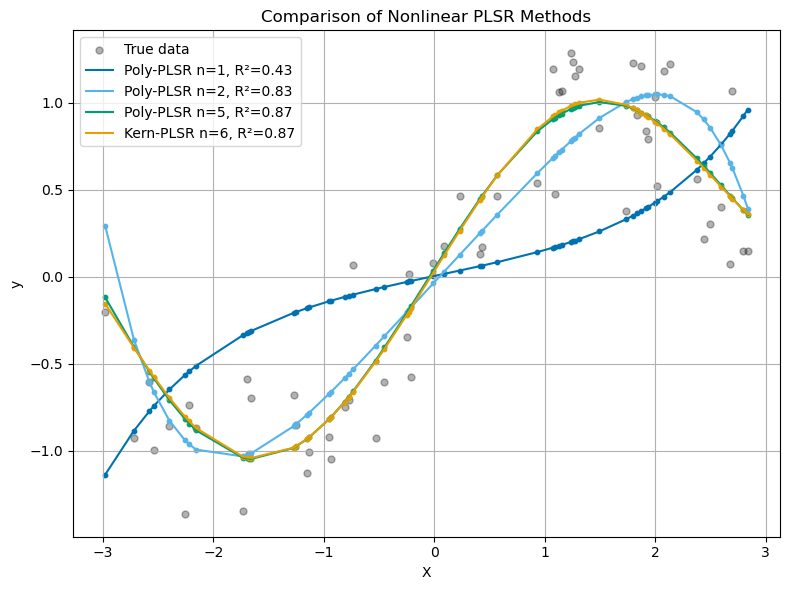

In [60]:
# ---- Plotting -------------------------------------------------------------------------
# Sort test data for smooth plotting
sorted_idx = np.argsort(X_test.ravel())
X_sorted = X_test[sorted_idx]
y_sorted_poly_1 = y_pred_poly_1[sorted_idx]
y_sorted_poly_2 = y_pred_poly_2[sorted_idx]
y_sorted_poly_5 = y_pred_poly_5[sorted_idx]
y_sorted_kernel = y_pred_kernel[sorted_idx]

# Color-blind friendly palette (CUD)
colors = {
    "poly_1": "#0072B2",  # blue
    "poly_2": "#56B4E9",  # sky blue
    "poly_5": "#009E73",  # bluish green
    "kernel": "#E69F00",  # orange
    "true": "#000000"     # black
}

# Plotting all methods
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label="True data", alpha=0.3, color=colors["true"], s=25)

# Plot each method with small dots and lines
plt.plot(X_sorted, y_sorted_poly_1, label=f"Poly-PLSR n=1, R²={r2_score(y_test, y_pred_poly_1):.2f}", color=colors["poly_1"], linewidth=1.5)
plt.scatter(X_sorted, y_sorted_poly_1, color=colors["poly_1"], s=10)

plt.plot(X_sorted, y_sorted_poly_2, label=f"Poly-PLSR n=2, R²={r2_score(y_test, y_pred_poly_2):.2f}", color=colors["poly_2"], linewidth=1.5)
plt.scatter(X_sorted, y_sorted_poly_2, color=colors["poly_2"], s=10)

plt.plot(X_sorted, y_sorted_poly_5, label=f"Poly-PLSR n=5, R²={r2_score(y_test, y_pred_poly_5):.2f}", color=colors["poly_5"], linewidth=1.5)
plt.scatter(X_sorted, y_sorted_poly_5, color=colors["poly_5"], s=10)

plt.plot(X_sorted, y_sorted_kernel, label=f"Kern-PLSR n={best_n}, R²={r2_score(y_test, y_pred_kernel):.2f}", color=colors["kernel"], linewidth=1.5)
plt.scatter(X_sorted, y_sorted_kernel, color=colors["kernel"], s=10)

# Final plot formatting
plt.title("Comparison of Nonlinear PLSR Methods")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

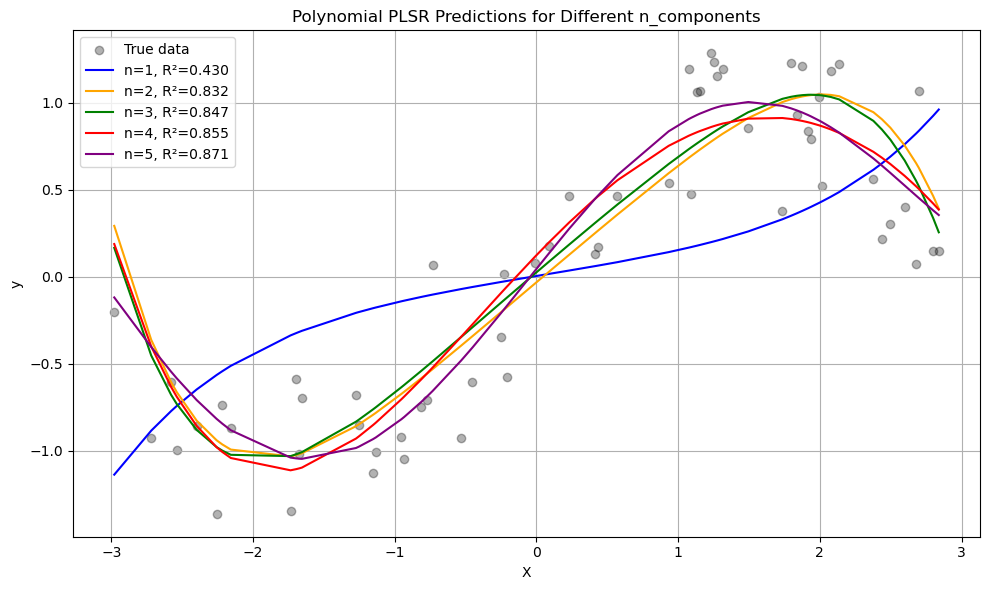

In [61]:

# Method 1: Polynomial feature expansion (explicit transformation) with different number of components. 
# Can store this as info, not to be used in presentation

# Plot setup
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label="True data", alpha=0.3, color='black')

# Try different n_components
components_list = [1, 2, 3, 4, 5]
colors = ['blue', 'orange', 'green', 'red', 'purple']

for n_comp, color in zip(components_list, colors):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X_poly_train, y_train)
    y_pred = pls.predict(X_poly_test)

    # Sort for smooth plotting
    sorted_idx = np.argsort(X_test.ravel())
    X_sorted = X_test[sorted_idx]
    y_sorted = y_pred[sorted_idx]

    r2 = r2_score(y_test, y_pred)
    plt.plot(X_sorted, y_sorted, label=f"n={n_comp}, R²={r2:.3f}", color=color)

plt.title("Polynomial PLSR Predictions for Different n_components")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 3: Derivation of a non-linear regression model

### Method 3: Use a spline function 
* Uses spline functions (e.g., B-splines) to model non-linear relationships between latent variables and response
* Requires knot selection and can be sensitive to overfitting
* Still has some level of interpretability

also called "Spline-based PLSR"

### Method 4: Use a NN to model the relationship between the latent variables and the responses
* Very flexible and powerful for modeling highly non-linear systems
* Requires careful training and regularization
* Interpretability is low

also called "NN-PLSR"


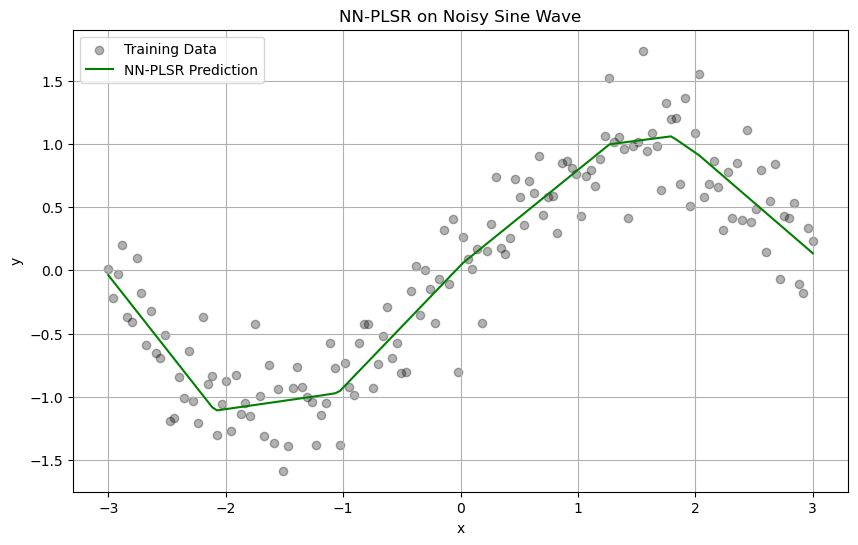

In [81]:
import torch
import torch.nn as nn

np.random.seed(42)
n_points=150
x = np.linspace(-3, 3, n_points).reshape(-1, 1)
y = np.sin(x).ravel() + 0.3*np.random.randn(n_points)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a simple neural network for regression
class RegressionNN(nn.Module):
    def __init__(self):
        nb_nodes = 8
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, nb_nodes),
            nn.ReLU(),
            nn.Linear(nb_nodes, nb_nodes),
            nn.ReLU(),
            nn.Linear(nb_nodes, 1)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model, define loss function and optimizer
model = RegressionNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

# Predict using the trained model
model.eval()
predicted = model(x_tensor).detach().numpy()

# Plot the original sine wave, noisy data, and model predictions
plt.figure(figsize=(10, 6))
# plt.plot(x, np.sin(x), label='Original Sine Wave', linestyle='--')
plt.scatter(x, y, label='Training Data', alpha=0.3, color='black')
plt.plot(x, predicted, label='NN-PLSR Prediction', color='green')
plt.legend()
plt.title('NN-PLSR on Noisy Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()



## Derivation of a non-linear regression model (cont.)
Are we still using least square approach in non linear regression models? 

**Spline-based PLSR**: YES! The regression coefficients are estimated by minimizing the squared error between predicted and actual responses.

**NN-PLSR**: YES but not always. NN can use a least squares loss function (MSE loss), combined with a gradient descent optimization method.

## Local Weighted PLSR

Another form of non-linear PLSR that will be adressed by another group :) 

# Non-linear PLSR - A summary

1. Introduce non-linearity in the feature space before deriving latent variables

   Method 1: Augment the **predictor matrix with polynomial terms**

   Method 2: Use Kernel functions to **map the original data into higer dimensional feature space**
   
3. Introduce non-linearity in derivation of regression model

   Method 3: Use a **spline function**

   Method 4: Use a **NN to model the relationship** between the latent variables and the responses


Comment: This are some options, but more methods can be applied


In [63]:
#Hilmi insert flow-chart as summary (or intro)

## References

PLSR
* https://www.youtube.com/watch?v=Vf7doatc2rA
* https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html 

Non-linear PLSR
* Rosipal, Roman. "Nonlinear partial least squares an overview." Chemoinformatics and advanced machine learning perspectives: complex computational methods and collaborative techniques (2011): 169-189. https://www.researchgate.net/publication/266488967_Nonlinear_Partial_Least_Squares_An_Overview